In [1]:
using HDF5,PyPlot,Statistics,LsqFit # Standard packages
using PyCall,FFTW,StatsBase,Images  # Standard packages
using FITSIO                        # Standard packages

# LazTech-VGT main codes
using LazCore,LazType,LazIO         # LazTech Basic Modules
using LazRHT,LazRHT_investigation   # Filament modules
using LazThermal,LazThermal_Kritsuk # Thermal broadening modules
using LazDust                       # The core package for MGT
using LazGAC                        # Gradient aand Curvature code
using LazCFA                        # CFA-related studies
using LazCh5                        # ch5-related studies
using LazMode                       # Mode decomposition 
using LazIN                         # Ion-neutral 
using LazRotation,LazRotationDev    # Rotation module
using LazSyntheticCube              # Synthetic cube synthesis
using LazTurbStat                   # Dora's Anisotropy code
using LazAMW                        # Smoothing
using LazLIC                        # LIC algorithm
using LazTsallis                    # Tsallis Statistics

# LazTech-VGT-new main codes
using LazDDA                        # Velocity Decomposition Algorithm
using LazFilament                   # Filamentary formation algorithm
using LazMultiGaussian              # Wing Channel ch6: Multigaussian fitting
using LazNewCore                    # New Gradient Algorithm
using LazNewCh5                     # ch5/ch9

# Accelerations
using Base.Threads                  # CPU Parallelism
#using ArrayFire                    # GPU Parallelism
using Profile                       # Profiling

# Interpolations
using Interpolations
# From Interpolations.CubicSplineInterpolation
sir=CubicSplineInterpolation

getmode=getmode_z
get_Bmode=get_Bmode_z
rotate=LazRotationDev.rotate_3d_vector

rotate_3d_vector (generic function with 1 method)

In [2]:
function sr(a;digits=2)
    return string(round(a,digits=2))
end

function si(a)
    return string(round(Int,a))
end

function imshowx(I;a=3,b=0,noleg=true)
    ima=imshow(I,vmin=mean(I)-b*std(I),vmax=mean(I)+a*std(I),cmap="RdGy_r")
    if noleg
        ax1.set_xticklabels([]);ax1.set_yticklabels([]);
    end
    return ima
end

function colorbarx(ima,PP;b=3,a=3,vlabel=L"$p_{v,HI}$")
    cbar=colorbar(ima,orientation="horizontal",fraction=0.046, pad=0.00,ticks=mean(PP).+std(PP).*Array(-b:a))
    cbar.ax.set_xticklabels([(c!=0 ? (c>0 ? L"$\langle $"*vlabel*L"$\rangle +$"*si(c)*L"$std($"*vlabel*L"$)$"
                                : L"$\langle $"*vlabel*L"$\rangle -$"*si(abs(c))*L"$std($"*vlabel*L"$)$"   
                                ) : L"$\langle$ "*vlabel*L"$ \rangle$") for c in -b:a],
                              rotation=270)
    return cbar
end

tight()=subplots_adjust(wspace=0,hspace=0);

function noticks()
    ax1.set_xticklabels([]);ax1.set_yticklabels([]);
end

function rs(a;dims=3)
    return reshape(sum(a,dims=dims),size(a)[1:2])
end

function smooth(a;b=2)
    return imfilter(a,Kernel.gaussian(b))
end

function hread(f,db)
    return convert(Array{Float32,3},read(f,db))
end


glob=pyimport("glob")

PyObject <module 'glob' from '/home/khyuen/.julia/conda/3/lib/python3.7/glob.py'>

In [3]:
glob=pyimport("glob")

PyObject <module 'glob' from '/home/khyuen/.julia/conda/3/lib/python3.7/glob.py'>

In [4]:
dbs=glob.glob("/mnt/d/data/128/*.full.h5")

30-element Vector{String}:
 "/mnt/d/data/128/b11-hdfaa.008.full.h5"
 "/mnt/d/data/128/b12-hdfaa.008.full.h5"
 "/mnt/d/data/128/b13-hdfaa.008.full.h5"
 "/mnt/d/data/128/b14-hdfaa.008.full.h5"
 "/mnt/d/data/128/b15-hdfaa.008.full.h5"
 "/mnt/d/data/128/b21-hdfaa.008.full.h5"
 "/mnt/d/data/128/b22-hdfaa.008.full.h5"
 "/mnt/d/data/128/b23-hdfaa.008.full.h5"
 "/mnt/d/data/128/b31-hdfaa.008.full.h5"
 "/mnt/d/data/128/b32-hdfaa.008.full.h5"
 "/mnt/d/data/128/b41-hdfaa.008.full.h5"
 "/mnt/d/data/128/b42-hdfaa.008.full.h5"
 "/mnt/d/data/128/b51-hdfaa.008.full.h5"
 ⋮
 "/mnt/d/data/128/h0-hdfaa.003.full.h5"
 "/mnt/d/data/128/h9-hdfaa.003.full.h5"
 "/mnt/d/data/128/run-0-hdfaa.007.full.h5"
 "/mnt/d/data/128/run-1-hdfaa.007.full.h5"
 "/mnt/d/data/128/run-2-hdfaa.007.full.h5"
 "/mnt/d/data/128/run-3-hdfaa.007.full.h5"
 "/mnt/d/data/128/run-4-hdfaa.007.full.h5"
 "/mnt/d/data/128/run-5-hdfaa.007.full.h5"
 "/mnt/d/data/128/run-6-hdfaa.007.full.h5"
 "/mnt/d/data/128/run-7-hdfaa.007.full.h5"
 "/mnt/d/data

# Illustration of the Zhang+2020's method

KH Yuen @ Apr 07, 2022, Madison, WI

## Below are the original implementation of Zhang et.al (2020)

Following https://arxiv.org/pdf/1808.01913.pdf

Notice:
- We are not considering the faraday rotation at all. We will tackle it in another template.
- I am going to print out the important figures in every steps to help everyone understanding the fundamental principle of the technique.



## Implementations Tutorial

In [5]:
# Eq.7: Var(ϵ_x) ~ Ucos^2ψ_s + V
# Eq.2: U ~ a_xx sin^2ψ_s + b_xx

function get_sxx(I::Mat,Q::Mat,U::Mat)
    phi=0.5.*atan.(U,Q);
    aa=zeros(0);
    bb=zeros(0);
    for phi_s in Array(0:1:360).*pi./180
        QQ=Q.*cos.(2.0.*phi_s).+U.*sin.(2.0.*phi_s)
        IQd2=(I.+QQ)./2.0;
        push!(aa,cmean(phi).+phi_s)
        # this nice formula only applies when mean field is perp to los
        push!(bb,var(IQd2))
    end
    return aa,bb
end

get_sxx (generic function with 1 method)

In [6]:
# h0-hdfaa.007
i=21;
f=h5open(dbs[i])
d=hread(f,"gas_density");
ib=hread(f,"i_mag_field");
jb=hread(f,"j_mag_field");
kb=hread(f,"k_mag_field");
iv=hread(f,"i_velocity");
jv=hread(f,"j_velocity");
kv=hread(f,"k_velocity");  

In [7]:
ib_A,jb_A,kb_A=PCA_decomposition(ib,jb,kb,mode="A");
ib_C,jb_C,kb_C=PCA_decomposition(ib,jb,kb,mode="C");

In [8]:
# ϵ=(I+Q)/2 = int dx B_z^2
# notice my mean field is <B_z>

nx,ny,nz=size(kb);
ϵ=rs(kb.^2.0,dims=1);



In [9]:
## Let us for convenience obtain also the mode-specific (I,Q,U)

# notice the decomposed modes (e.g. kb_A) has mean zero
# one has to add it back.

kbm=mean(kb)

# The current construction will lead to ϵ_A=0 
# (kb_A=0 when projected along mean field direction)
# to make the analysis doable, rotate the cube a bit before doing.

γ=pi/180

ib_X,jb_X,kb_X=rotate(ib,jb,kb,0,γ,0)
ib_A,jb_A,kb_A=rotate(ib_A,jb_A,kb_A.+kbm,0,γ,0)
ib_C,jb_C,kb_C=rotate(ib_C,jb_C,kb_C.+kbm,0,γ,0)



# notice we are assuming relativistic electron density = const
# a strong assumption, through
I=rs(kb_X.^2.0.+jb_X.^2.0);
Q=rs(kb_X.^2.0.-jb_X.^2.0);
U=rs(2.0.*kb_X.*jb_X);


I_A=rs(kb_A.^2.0.+jb_A.^2.0);
Q_A=rs(kb_A.^2.0.-jb_A.^2.0);
U_A=rs(2.0.*kb_A.*jb_A);

I_C=rs(kb_C.^2.0.+jb_C.^2.0);
Q_C=rs(kb_C.^2.0.-jb_C.^2.0);
U_C=rs(2.0.*kb_C.*jb_C);

In [10]:
mean(ϵ),mean(0.5.*(I_A.+Q_A))

(217989.72103296602, 217255.53754955277)

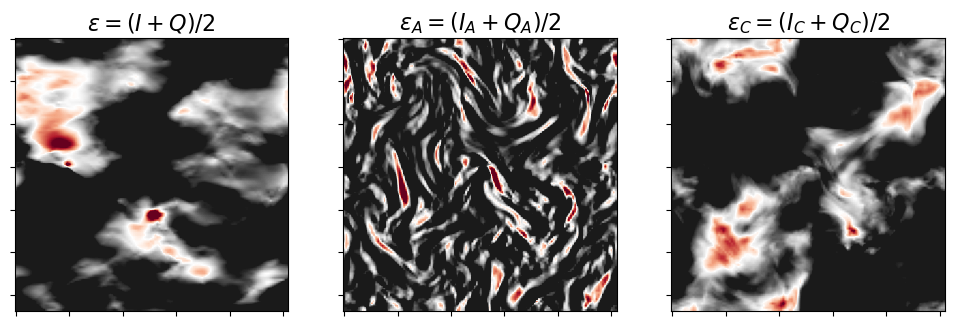

PyObject Text(0.5, 1.0, '$\\epsilon_C=(I_C+Q_C)/2$')

In [11]:
figure(figsize=(12,4))
ax1=subplot(131)
imshowx(ϵ)
title(L"$\epsilon=(I+Q)/2$",fontsize=16)
ax1=subplot(132)
imshowx(0.5.*(I_A.+Q_A))
title(L"$\epsilon_A=(I_A+Q_A)/2$",fontsize=16)
ax1=subplot(133)
imshowx(0.5.*(I_C.+Q_C))
title(L"$\epsilon_C=(I_C+Q_C)/2$",fontsize=16)

In [12]:
ϕ_s,s_xx=get_sxx(I,Q,U);
ϕ_sA,s_xxA=get_sxx(I_A,Q_A,U_A);
ϕ_sC,s_xxC=get_sxx(I_C,Q_C,U_C);

In [13]:
# eq19
function ζ_xx(s_xx)
    return (maximum(s_xx)-minimum(s_xx))./(maximum(s_xx)+minimum(s_xx))
end

ζ_xx (generic function with 1 method)

In [14]:
# eq.y
function y_xx(ϕ_s,s_xx)
    # notice range for ϕ is [0,2pi]
    s_max=maximum(s_xx)
    s_min=minimum(s_xx)
    # we dont need condition (1) for axis-symmetry, that is
    # automatically tackled with the shift algorithm above
    s_denominator=0.5.*(s_max+s_min)
    
    s_2 = 0
    s_4 = 0
    Δϕ=abs(diff(ϕ_s)[1])
    
    for i in 1:length(ϕ_s)-1
        # trap rule
        s_2+=0.5.*(s_xx[i]*sin(2.0.*ϕ_s[i]).+s_xx[i+1]*sin(2.0.*ϕ_s[i+1]))*Δϕ
        s_4+=0.5.*(s_xx[i]*sin(4.0.*ϕ_s[i]).+s_xx[i+1]*sin(4.0.*ϕ_s[i+1]))*Δϕ
    end
    
    return sqrt(s_2^2+s_4^2)/s_denominator
        
end

y_xx (generic function with 1 method)

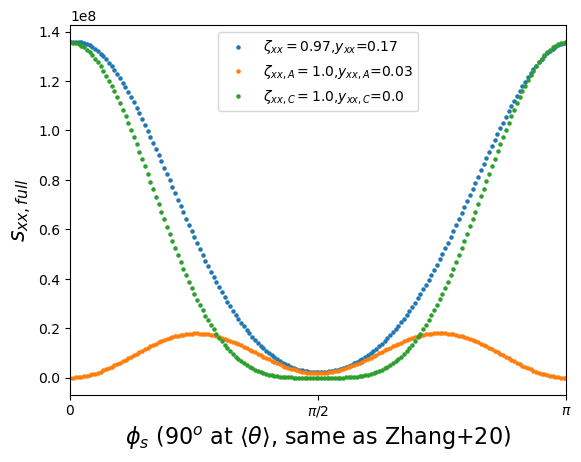

(PyObject[PyObject <matplotlib.axis.XTick object at 0x7f987fc7dcf8>, PyObject <matplotlib.axis.XTick object at 0x7f987fc7dcc0>, PyObject <matplotlib.axis.XTick object at 0x7f987fc7d908>], PyObject[PyObject Text(0.0, 0, '$0$'), PyObject Text(1.5707963267948966, 0, '$\\pi/2$'), PyObject Text(3.141592653589793, 0, '$\\pi$')])

In [15]:
# one can see from this figure that the A and C mode in this figure
# behaves significantly. This is the foundation of the SPA technique

scatter(ϕ_s,s_xx,s=5,label=L"$\zeta_{xx}=$"*sr(ζ_xx(s_xx))*L",$y_{xx}$="*sr(y_xx(ϕ_s,s_xx)))
scatter(ϕ_sA,s_xxA,s=5,label=L"$\zeta_{xx,A}=$"*sr(ζ_xx(s_xxA))*L",$y_{xx,A}$="*sr(y_xx(ϕ_sA,s_xxA)))
scatter(ϕ_sC,s_xxC,s=5,label=L"$\zeta_{xx,C}=$"*sr(ζ_xx(s_xxC))*L",$y_{xx,C}$="*sr(y_xx(ϕ_sC,s_xxC)))
xlabel(L"$\phi_s$ ($90^o$ at $\langle\theta\rangle$, same as Zhang+20)",fontsize=16)
ylabel(L"$s_{xx,full}$",fontsize=16)
legend(bbox_to_anchor=(0.5,1), loc="upper center", ncol=1)
xlim(0,pi)
xticks(Array(0:90:180).*pi./180,[L"$0$",L"$\pi/2$",L"$\pi$"])

In [16]:
## we are not done yet. The first thing we should do is to remove the constant term in s_xx
## to do this, we define a function s_xx = s̄_xx cos^2(ϕ_s) + C (eq.7)
## and we just aim at retaining the first part. 
## In numerical simulations one can just write s̄_xx = s_xx - min(s_xx)
## but one cannot do this in observations. Instead, please fit it.

## also, the usage of p[1] and p[2] here are just temporal

s_linear(x,p)=(p[1].*sin.(x).*sin.(x).+p[2]).*cos.(x).*cos.(x).+p[3];

In [17]:
function linearize_s(ϕ_s,s_xx)
    ffit=curve_fit(s_linear,ϕ_s,s_xx,[rand(3)...])
    # rmb: one cannot write ffit.param[1]*cos^2(x)
    return s_xx .- ffit.param[3]
end

linearize_s (generic function with 1 method)

In [18]:
# one can see from this figure that the A and C mode in this figure
# behaves significantly. This is the foundation of the SPA technique

scatter(ϕ_s,s_xx,s=5,label="original,z="*sr(ζ_xx(s_xx)))
s_xxl=linearize_s(ϕ_s,s_xx)
scatter(ϕ_s,s_xxl,s=5,label="linearized,z="*sr(ζ_xx(s_xxl)))
plot(ϕ_s,s_linear(ϕ_s,ff),color="r",linestyle="--")

xlabel(L"$\phi_s$ ($90^o$ at $\langle\theta\rangle$, same as Zhang+20)",fontsize=16)
ylabel(L"$s_{xx,full}$",fontsize=16)
legend(bbox_to_anchor=(0.5,1), loc="upper center", ncol=1)
xlim(0,pi)
xticks(Array(0:90:180).*pi./180,[L"$0$",L"$\pi/2$",L"$\pi$"])

LoadError: UndefVarError: ff not defined

In [19]:
# This form is not that convenient to obtain a,b
# now Eq.20, compute near $ϕ_s=90$

function s_fluc(ϕ_s,s_xx,Δϕ_s;θ_mean=pi/2)
    # notice, multiple Δϕ_s is required to obtain ̂a_xx,̂b_xx
    Δϕ=abs(diff(ϕ_s)[1])
    
    s_f=0;
    
    for i in 1:length(ϕ_s)-1
        dϕ=0.5*(ϕ_s[i]+ϕ_s[i+1])-θ_mean
        if abs(dϕ)<Δϕ_s
            s_f += 0.5*(s_xx[i]+s_xx[i+1])*Δϕ
        end
    end
    # we will not divide 2Δϕ_s, 
    # but when we model this equation (eq.21)
    # we will use (...)/16
    return s_f# ./Δϕ_s./2.0
    
end

s_fluc (generic function with 1 method)

In [20]:
s_model(x,p)=(4.0.*(p[1].+4.0.*p[2]).*x.-8.0.*p[2].*sin.(2.0.*x).-p[1].*sin.(4.0.*x))./16

s_model (generic function with 1 method)

In [21]:
Δϕ_s=0.01:0.01:pi/4

0.01:0.01:0.78

In [22]:
# eq20
function s_fluc_array(ϕ_s,s_xx,Δϕ_s;θ_mean=pi/2)
    s_f=zeros(length(Δϕ_s))
    for i in 1:length(Δϕ_s)
        s_f[i]=s_fluc(ϕ_s,s_xx,Δϕ_s[i],θ_mean=θ_mean)
    end
    return s_f
end

s_fluc_array (generic function with 1 method)

In [23]:
# here we will use directly the non-linearized s_xx
# it's okay given that ζ≈1 for our s_xx

s_f=s_fluc_array(ϕ_s,s_xx,Δϕ_s;θ_mean=pi/2);
s_fA=s_fluc_array(ϕ_sA,s_xxA,Δϕ_s;θ_mean=pi/2);
s_fC=s_fluc_array(ϕ_sC,s_xxC,Δϕ_s;θ_mean=pi/2);

In [24]:
fitt  =curve_fit(s_model,Δϕ_s,s_f ,[rand(2)...]);
fitt_A=curve_fit(s_model,Δϕ_s,s_fA,[rand(2)...]);
fitt_C=curve_fit(s_model,Δϕ_s,s_fC,[rand(2)...]);

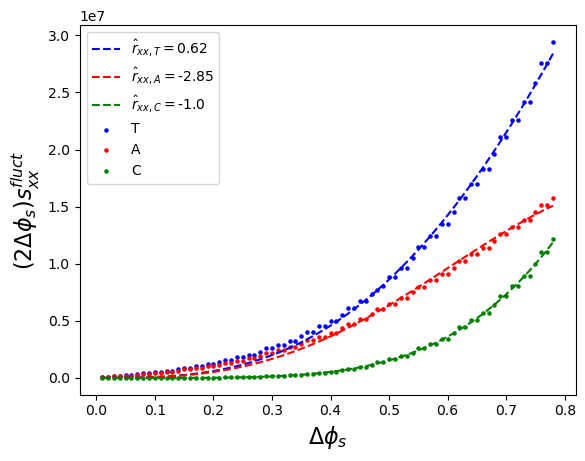

PyObject <matplotlib.legend.Legend object at 0x7f987fa88898>

In [25]:
scatter(Δϕ_s,s_f ,s=5,label="T",color="b")
scatter(Δϕ_s,s_fA,s=5,label="A",color="r")
scatter(Δϕ_s,s_fC,s=5,label="C",color="g")
plot(Δϕ_s,s_model(Δϕ_s,fitt.param),color="b",linestyle="--"
    ,label=L"$\hat{r}_{xx,T}=$"*sr(fitt.param[1]/fitt.param[2]))
plot(Δϕ_s,s_model(Δϕ_s,fitt_A.param),color="r",linestyle="--"
    ,label=L"$\hat{r}_{xx,A}=$"*sr(fitt_A.param[1]/fitt_A.param[2]))
plot(Δϕ_s,s_model(Δϕ_s,fitt_C.param),color="g",linestyle="--"
    ,label=L"$\hat{r}_{xx,C}=$"*sr(fitt_C.param[1]/fitt_C.param[2]))
#xticks(Δϕ_s)
xlabel(L"$\Delta \phi_s$",fontsize=16)
ylabel(L"$(2\Delta\phi_s)s_{xx}^{fluct}$",fontsize=16)
legend(loc=2)

In [26]:
# notice that in theory r_{xx} (without hat) can be computed per-point.
# so a fitting is not necessary.
# the selection of Δϕ_s is not obvious

r_fac=(@. 2*sin(2*Δϕ_s)/sin(4*Δϕ_s));

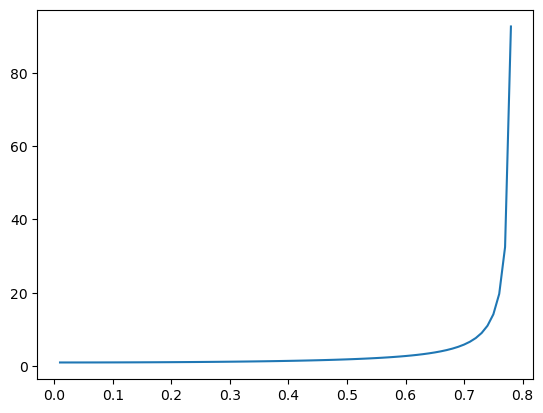

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f987fbceb00>

In [27]:
# notice that the factor to convert r\hat to r is not a constant.

plot(Δϕ_s,r_fac)

In [28]:
# therefore what we can do is to **assume** Δϕ_s = δθ

δθ   = cstd(0.5.*atan.(U  ,Q));
δθ_A = cstd(0.5.*atan.(U_A,Q_A));
δθ_C = cstd(0.5.*atan.(U_C,Q_C));

## Dependence of $r_{xx}$ to $C/A$

In [29]:
# and we pack all functions above together

function get_rxx(I,Q,U;δθ=cstd(0.5.*atan.(U  ,Q)),θ_mean=pi/2,Δϕ_s=0.01:0.01:pi/4)
    # get s_xx
    ϕ_s,s_xx=get_sxx(I,Q,U);
    # get ζ
    ζ=ζ_xx(s_xx)
    # get y
    y=y_xx(ϕ_s,s_xx)
    # linearize 
    s_xx=linearize_s(ϕ_s,s_xx)
    # get s_f (eq.21)
    s_f=s_fluc_array(ϕ_s,s_xx,Δϕ_s;θ_mean=θ_mean);
    # we are taking the regression value of r̂_xx (eq.22)
    fitt  =curve_fit(s_model,Δϕ_s,s_f ,[rand(2)...]);
    return fitt.param[1]/fitt.param[2]*2*sin(2*δθ)/sin(4*δθ)
    
end

get_rxx (generic function with 1 method)

In [30]:
# now we can loop over the data cubes.
# the way to do this is not to use the [-1,-1/3,1/3,1] discretization in zhang et.al 2020 
# but just directly plotting the graph
# on r_xx vs C/A


r_array=zeros(0)
CA_array=zeros(0)

for db in dbs
    f=h5open(db)
    d=hread(f,"gas_density");
    ib=hread(f,"i_mag_field");
    jb=hread(f,"j_mag_field");
    kb=hread(f,"k_mag_field");
    iv=hread(f,"i_velocity");
    jv=hread(f,"j_velocity");
    kv=hread(f,"k_velocity");      
    
    
    ib_A,jb_A,kb_A=PCA_decomposition(ib,jb,kb,mode="A");
    ib_C,jb_C,kb_C=PCA_decomposition(ib,jb,kb,mode="C");
    
    # the relative energy ratio between alf and comp waves
    # in the form of B^2
    push!(CA_array,(var(ib_C)+var(jb_C)+var(kb_C))/(var(ib_A)+var(jb_A)+var(kb_A)))
    
    I=rs(kb.^2.0.+jb.^2.0);
    Q=rs(kb.^2.0.-jb.^2.0);
    U=rs(2.0.*kb.*jb);
    
    r_xx=get_rxx(I,Q,U)
    push!(r_array,r_xx)
    println(db*" done!")
   
end


/mnt/d/data/128/b11-hdfaa.008.full.h5 done!
/mnt/d/data/128/b12-hdfaa.008.full.h5 done!
/mnt/d/data/128/b13-hdfaa.008.full.h5 done!
/mnt/d/data/128/b14-hdfaa.008.full.h5 done!
/mnt/d/data/128/b15-hdfaa.008.full.h5 done!
/mnt/d/data/128/b21-hdfaa.008.full.h5 done!
/mnt/d/data/128/b22-hdfaa.008.full.h5 done!
/mnt/d/data/128/b23-hdfaa.008.full.h5 done!
/mnt/d/data/128/b31-hdfaa.008.full.h5 done!
/mnt/d/data/128/b32-hdfaa.008.full.h5 done!
/mnt/d/data/128/b41-hdfaa.008.full.h5 done!
/mnt/d/data/128/b42-hdfaa.008.full.h5 done!
/mnt/d/data/128/b51-hdfaa.008.full.h5 done!
/mnt/d/data/128/b52-hdfaa.008.full.h5 done!
/mnt/d/data/128/e5r2-hdfaa.031.full.h5 done!
/mnt/d/data/128/e5r3-hdfaa.003.full.h5 done!
/mnt/d/data/128/e6r3-hdfaa.003.full.h5 done!
/mnt/d/data/128/e7r3-hdfaa.003.full.h5 done!
/mnt/d/data/128/h0-hdfaa.003.full.h5 done!
/mnt/d/data/128/h9-hdfaa.003.full.h5 done!
/mnt/d/data/128/run-0-hdfaa.007.full.h5 done!
/mnt/d/data/128/run-1-hdfaa.007.full.h5 done!
/mnt/d/data/128/run-2-hdfa

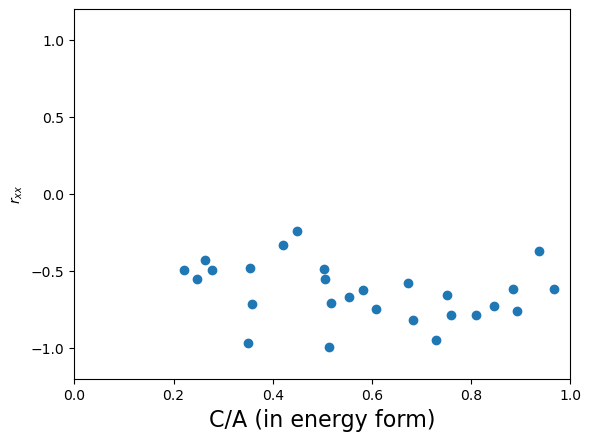

(-1.2, 1.2)

In [31]:
# however simulations usually have inadequate variations of C/A (e.g. a solendoial-driven sim usually must have C/A<1 as we see below)


scatter(CA_array,r_array)
xlabel("C/A (in energy form)",fontsize=16)
ylabel(L"$r_{xx}$")
xlim(0,1)
ylim(-1.2,1.2)

In [32]:
f=h5open(dbs[i])
d=hread(f,"gas_density");
ib=hread(f,"i_mag_field");
jb=hread(f,"j_mag_field");
kb=hread(f,"k_mag_field");
iv=hread(f,"i_velocity");
jv=hread(f,"j_velocity");
kv=hread(f,"k_velocity"); 

In [33]:
ib_A,jb_A,kb_A=PCA_decomposition(ib,jb,kb,mode="A");
ib_C,jb_C,kb_C=PCA_decomposition(ib,jb,kb,mode="C");

In [ ]:
# so what we need to do is to manipulate our simulations

r_array=zeros(0)
mode_array=zeros(0)

for modefrac=0.01:0.01:1.0
    
    ib_X=modefrac.*ib_A.+(1.0.-modefrac).*ib_C
    jb_X=modefrac.*jb_A.+(1.0.-modefrac).*jb_C
    kb_X=modefrac.*kb_A.+(1.0.-modefrac).*kb_C.+mean(kb) # remember to add the mean field back
    
    push!(mode_array,modefrac) 
    I=rs(kb_X.^2.0.+jb_X.^2.0);
    Q=rs(kb_X.^2.0.-jb_X.^2.0);
    U=rs(2.0.*kb_X.*jb_X);
    
    r_xx=get_rxx(I,Q,U)
    push!(r_array,r_xx)
    println(sr(modefrac)*" done!")
   
end


0.01 done!
0.02 done!
0.03 done!
0.04 done!
0.05 done!
0.06 done!
0.07 done!
0.08 done!
0.09 done!
0.1 done!
0.11 done!
0.12 done!
0.13 done!
0.14 done!
0.15 done!
0.16 done!
0.17 done!
0.18 done!
0.19 done!
0.2 done!
0.21 done!
0.22 done!
0.23 done!
0.24 done!
0.25 done!
0.26 done!
0.27 done!
0.28 done!
0.29 done!
0.3 done!
0.31 done!
0.32 done!
0.33 done!
0.34 done!
0.35 done!
0.36 done!
0.37 done!
0.38 done!
0.39 done!
0.4 done!
0.41 done!
0.42 done!
0.43 done!
0.44 done!
0.45 done!
0.46 done!
0.47 done!
0.48 done!
0.49 done!
0.5 done!
0.51 done!
0.52 done!
0.53 done!
0.54 done!
0.55 done!
0.56 done!
0.57 done!
0.58 done!
0.59 done!
0.6 done!
0.61 done!
0.62 done!
0.63 done!
0.64 done!
0.65 done!
0.66 done!
0.67 done!
0.68 done!
0.69 done!
0.7 done!
0.71 done!
0.72 done!
0.73 done!
0.74 done!
0.75 done!
0.76 done!
0.77 done!
0.78 done!
0.79 done!
0.8 done!
0.81 done!
0.82 done!
0.83 done!
0.84 done!
0.85 done!


In [ ]:
# however simulations usually have inadequate variations of C/A (e.g. a solendoial-driven sim usually must have C/A<1 as we see below)


scatter(mode_array,r_array)
xlabel("mode frac = A/(A+C)",fontsize=16)
ylabel(L"$r_{xx}$")
xlim(0,0.8)
ylim(-1.2,1.2)
